This notebook uses the wind speed and power output data from the National Renewable Enery Labs' Eastern Wind Data Set: https://www.nrel.gov/grid/eastern-wind-data.html

The goal of this notebook is to use this data to verify that the wind speeds follow a Weibull Distribution and that the power curves generated by the data set are proportional to the wind velocity cubed. We also perform a regression on the power curve data in order to solve for the predicted overall power coefficient (COP) of the turbine being modeled.

In [199]:
import pandas as pd
import scipy.stats as s
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

We begin by importing wind speed and power output data for a hypothetical site located at (36.5,-99.9375) degrees latitude and longitude. The data set consists of 10 minute time series data over the year 2005, giving values for the wind speed at heights of 80 and 100 meters as well as predicted power output in kilowatts of three different types of wind turbines (IEC1, IEC2, IEC3).

In [200]:
speed_data=pd.read_csv('311-2005.csv',header=3)

In [214]:
speed_data.head(10)

,Year,Month,Day,Hour,Minute,Wind Speed 80m (m/s),Wind Speed 100m (m/s),IEC1 80m,IEC2 80m,IEC3 100m,Selected IEC1
0,2005,1,1,0,0,5.223,5.568,17.0,22.2,32.3,22.2
1,2005,1,1,0,10,5.000,5.383,13.6,18.0,28.2,18.0
2,2005,1,1,0,20,4.823,5.206,11.4,15.2,25.2,15.2
3,2005,1,1,0,30,4.526,4.936,8.0,11.0,20.6,11.0
4,2005,1,1,0,40,4.548,5.023,8.7,11.9,22.7,11.9
5,2005,1,1,0,50,4.308,4.892,6.8,9.3,20.8,9.3
6,2005,1,1,1,0,4.450,5.095,8.3,11.2,24.3,11.2
7,2005,1,1,1,10,5.276,5.941,19.0,24.3,41.9,24.3
8,2005,1,1,1,20,5.998,6.634,29.8,37.2,56.8,37.2
9,2005,1,1,1,30,6.514,7.083,40.3,49.7,70.9,49.7


In [228]:
speed_data['IEC2 80m'].sum()*10**-6

6.308458399999999

We examine the velocity distribution of the wind speed at 80m:

In [202]:
data=speed_data['Wind Speed 80m (m/s)'].values

In [203]:
data.min() , data.max(), data.mean()

(0.127, 23.124, 8.312520890410958)

We see that our wind speed ranges from .127 to 23.124 m/s, with an average of about 8.3125 m/s

Next we plot a histogram of the distribution of wind speeds:

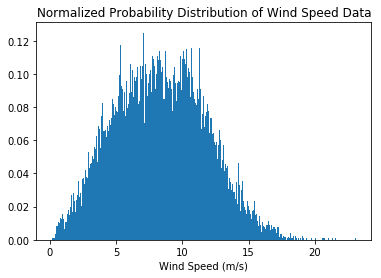

In [204]:
plt.hist(data, 1000, density=True)
plt.xlabel('Wind Speed (m/s)')
plt.title('Normalized Probability Distribution of Wind Speed Data')
plt.show()

In [205]:
weib

(1, 2.5734177922491948, 0, 9.353845782206644)

Next we show that the data follows a Weibull distribution:

$f(v)=(\frac{k}{c})(\frac{v}{c})^{k-1}e^{-(\frac{v}{c})^{k}}$

Where v is wind velocity, k is the weibull shape parameter, and c is the Weibull scale parameter.

The first line in the following code cell fits a Weibull distribution curve to our data, then the remaining lines plot the curve over the historgram from before

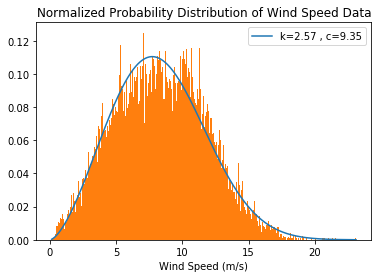

In [206]:
weib=s.exponweib.fit(data,floc=0,f0=1)
x = np.linspace(data.min(), data.max(), 1000)
plt.plot(x, s.exponweib.pdf(x, weib[0], weib[1],weib[2],weib[3]),label='k='+str(np.round(weib[1],2))+' , '+'c='+str(np.round(weib[3],2)))
plt.xlabel('Wind Speed (m/s)')
plt.title('Normalized Probability Distribution of Wind Speed Data')
plt.legend()
plt.hist(data, 1000, density=True)
plt.show()

We see that a Weibull distribution with k= 2.57 and c= 9.35 fits the wind speed data very well. Next we use the simulated power output data of a chosen turbine (IEC2) to plot a power curve.

In [207]:
speed_data_sorted=speed_data.sort_values('Wind Speed 80m (m/s)')

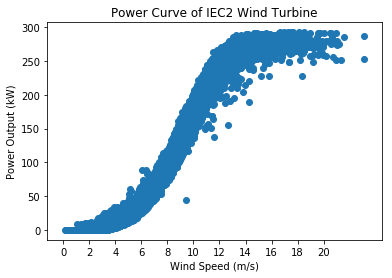

In [208]:
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.xticks(np.arange(0, 21, step=2))
plt.title('Power Curve of IEC2 Wind Turbine')
plt.scatter(speed_data_sorted['Wind Speed 80m (m/s)'],speed_data_sorted['IEC2 80m'])


This power curve is approximately a cubic function of wind speed in the range of  about 3-12 m/s. Below 3 m/s the turbine is expected to produce close to zero watts of power, this corresponds to the cut-in speed of the trubine. On the other end of the spectrum we have a rated speed of about 12 m/s, the turbine power output will not increase past this value. 

Below we isolate the data in this range in order to fit the cubic portion of the power curve.

In [209]:
cutoff_excl_speed=speed_data_sorted[np.logical_and(speed_data_sorted['Wind Speed 80m (m/s)']<=12,speed_data_sorted['Wind Speed 80m (m/s)']>=3)]['Wind Speed 80m (m/s)']
cutoff_excl_power=speed_data_sorted[np.logical_and(speed_data_sorted['Wind Speed 80m (m/s)']<=12,speed_data_sorted['Wind Speed 80m (m/s)']>=3)]['IEC2 80m']
                                                        

Next we divide the data into training and test sets, and perform the linear regression

In [210]:
X_train, X_test, y_train, y_test = train_test_split(cutoff_excl_speed.values.reshape(-1, 1)**3, cutoff_excl_power.values, test_size=0.33)

In [211]:
regressor = LinearRegression(fit_intercept=False)
regressor.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

Below we calculate the $r^{2}$ for our regression, from which we can that our regression is in very good agreement with the data

In [212]:
y_predict=regressor.predict(X_test)
print('r^2 =' + str(r2_score(y_test,y_predict)))


r^2 =0.9730593051774187


Next we overlay the fit onto the data

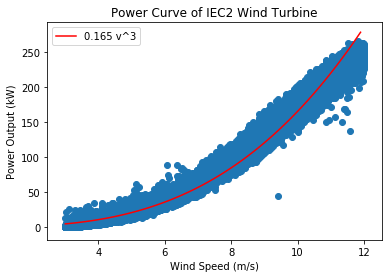

In [213]:

x=np.arange(3,12,.1)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.plot(x,regressor.predict(x.reshape(-1,1)**3),'r',label=str(np.round(regressor.coef_[0],3))+' '+'v^3')
plt.title('Power Curve of IEC2 Wind Turbine')
plt.legend()
plt.scatter(cutoff_excl_speed.values,cutoff_excl_power.values)

Where our power curve has equation $P = .165 v^{3}$ (P is output power and v is wind speed). The slope has units kilo-Watts per ten minutes, to get it in kilowatt hours we multiply by 6 to obtain:

$P = .99 v^{3}$ 

Finally, we use our fit to calculate the overall power coefficient. The theoretical power output (P) of a wind turbine is:

$P= COP~\frac{1}{2}\rho~A~v^{3}*10^{-3}$ kilo-Watt hours

Where COP is the power coefficent, $\rho$ is the air density, and A is the area swept by the turbine blades.
            
See: Tester, Jefferson W. Sustainable Energy Choosing Among Options . 2nd ed. Cambridge, MA: MIT Press, 2012. Print.         

Subsitiuting $P = .99 v^{3}$ into the above equation yields:

$COP=\frac{1980}{\rho A}$

And from https://www.nrel.gov/docs/fy10osti/46764.pdf , the air density assumed in the data set is 1.225 kg/$\text{m}^{3}$ and the turbine area is ~ 5027 $\text{m}^{2}$. So we have:

$COP = .3215$

Which is slightly better than the typical value of 0.3 given in the reference above.